
# Indian Sign Language (ISL) Character Recognition  
### Data Science & Computer Vision Project – **DataMites™**  

**Project Code:** PRAICP-1000-IndiSignLang  
**Project Member:** Anant Anubhav


---



## Business Case  
Indian Sign Language (ISL) recognition is critical for improving accessibility and communication for the deaf and hard-of-hearing community in India.  
This project builds a deep learning-based image classification system to automatically recognize ISL characters from images.

## Project Goals  
1. Perform detailed Exploratory Data Analysis (EDA) on ISL image data  
2. Apply image preprocessing and data augmentation  
3. Build and compare CNN and Transfer Learning models  
4. Evaluate model performance using classification metrics  
5. Save trained models for deployment  
6. Demonstrate inference on new images  



## Dataset Description  

- **Dataset Type:** Image (Character-level ISL)  
- **Total Images:** ~42,700  
- **Number of Classes:** 35 (Digits 1–9 and Alphabets A–Z)  
- **Structure:** Directory-based dataset (each folder represents a character)  
- **Note:** Digit `0` is not included as it is identical to ASL  

The dataset is well-balanced and suitable for multi-class image classification.


In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
import pickle


In [5]:

BASE_DIR = "../Dataset"   # Updated path to dataset folder
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
MODEL_SAVE_DIR = "saved_models"

# Create directory for saving models
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)



## Exploratory Data Analysis (EDA)
### Class Distribution


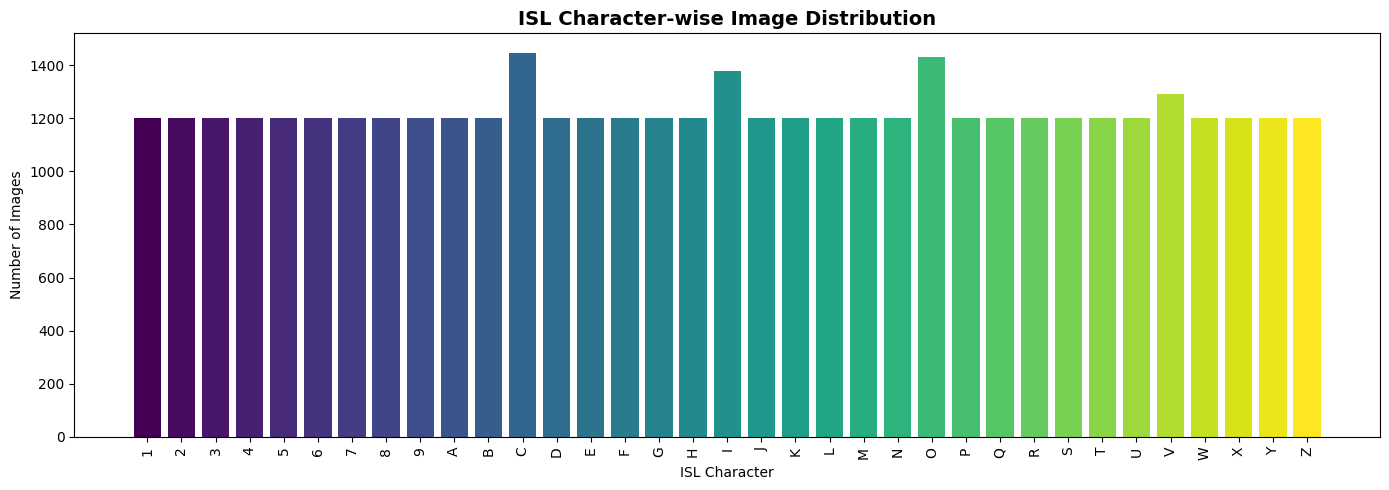


📊 Total Classes: 35
📷 Total Images: 42745
📈 Avg Images per Class: 1221


In [6]:

classes = sorted([c for c in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, c))])
counts = [len(os.listdir(os.path.join(BASE_DIR, c))) for c in classes]

plt.figure(figsize=(14,5))
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
plt.bar(classes, counts, color=colors)
plt.title("ISL Character-wise Image Distribution", fontsize=14, fontweight='bold')
plt.xlabel("ISL Character")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(f"\n📊 Total Classes: {len(classes)}")
print(f"📷 Total Images: {sum(counts)}")
print(f"📈 Avg Images per Class: {sum(counts)//len(classes)}")



**Observation:**  
The dataset is largely balanced across all ISL characters, which reduces bias during training.



### Sample Images from Dataset


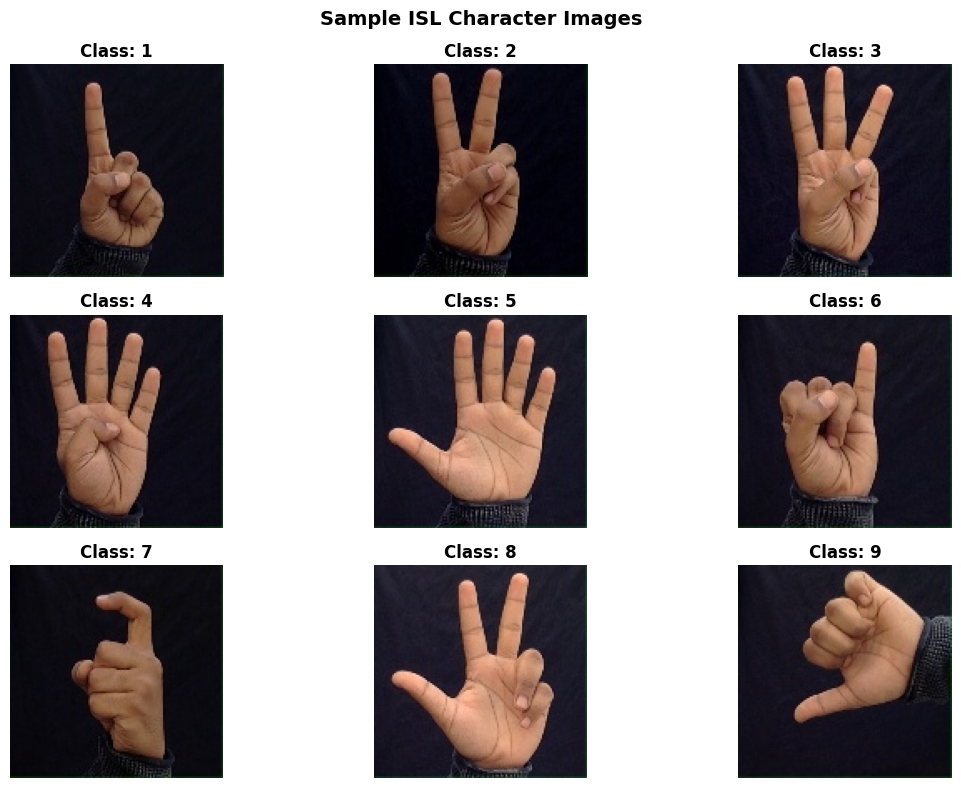

In [7]:

plt.figure(figsize=(12,8))
for i, cls in enumerate(classes[:9]):
    img_path = os.path.join(BASE_DIR, cls, os.listdir(os.path.join(BASE_DIR, cls))[0])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"Class: {cls}", fontweight='bold')
    plt.axis('off')
plt.suptitle("Sample ISL Character Images", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



## Data Preprocessing & Augmentation


In [8]:

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Save class indices for inference
class_indices = train_gen.class_indices
class_labels = {v: k for k, v in class_indices.items()}
print(f"\n✅ Classes: {list(class_indices.keys())}")


Found 34198 images belonging to 35 classes.
Found 8547 images belonging to 35 classes.

✅ Classes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']



### Data Augmentation Example


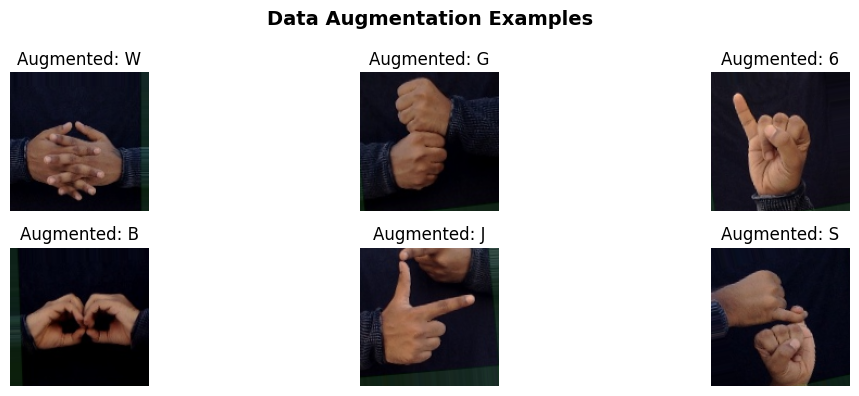

In [9]:

sample_img, sample_labels = next(train_gen)
plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_img[i])
    pred_class = class_labels[np.argmax(sample_labels[i])]
    plt.title(f"Augmented: {pred_class}")
    plt.axis('off')
plt.suptitle("Data Augmentation Examples", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



## Model 1: Custom CNN


In [10]:

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


d:\Indian Sign Language (ISL)\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,525,027 (24.89 MB)

 Trainable params: 6,525,027 (24.89 MB)

 Non-trainable params: 0 (0.00 B)


## Model 2: Transfer Learning (MobileNetV2)


In [11]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_gen.num_classes, activation='softmax')(x)

tl_model = Model(inputs=base_model.input, outputs=outputs)

tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tl_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,594,915 (9.90 MB)

 Trainable params: 336,931 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


## Model Training with Checkpointing


In [12]:

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# CNN Model Checkpoint
cnn_checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_SAVE_DIR, 'cnn_best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Transfer Learning Model Checkpoint
tl_checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_SAVE_DIR, 'mobilenet_best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("\n🚀 Training Custom CNN Model...")
cnn_history = cnn_model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=10, 
    callbacks=[early_stop, cnn_checkpoint]
)

print("\n🚀 Training MobileNetV2 Transfer Learning Model...")
tl_history = tl_model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=10, 
    callbacks=[early_stop, tl_checkpoint]
)



🚀 Training Custom CNN Model...
Epoch 1/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.6780 - loss: 1.1255
Epoch 1: val_accuracy improved from None to 0.97590, saving model to saved_models\cnn_best_model.keras
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 1116s 1s/step - accuracy: 0.8567 - loss: 0.4807 - val_accuracy: 0.9759 - val_loss: 0.2765
Epoch 2/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9676 - loss: 0.1020
Epoch 2: val_accuracy improved from 0.97590 to 0.98257, saving model to saved_models\cnn_best_model.keras
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 525s 491ms/step - accuracy: 0.9744 - loss: 0.0788 - val_accuracy: 0.9826 - val_loss: 0.2985
Epoch 3/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9820 - loss: 0.0559
Epoch 3: val_accuracy improved from 0.98257 to 0.98397, saving model to saved_models\cnn_best_model.keras
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 465s 435ms/step - accuracy: 0.9833 - loss: 0.0532 - val_accuracy: 0.9840 - val_loss: 0.3192
Epoch 4/10
1069/


## Training History Visualization


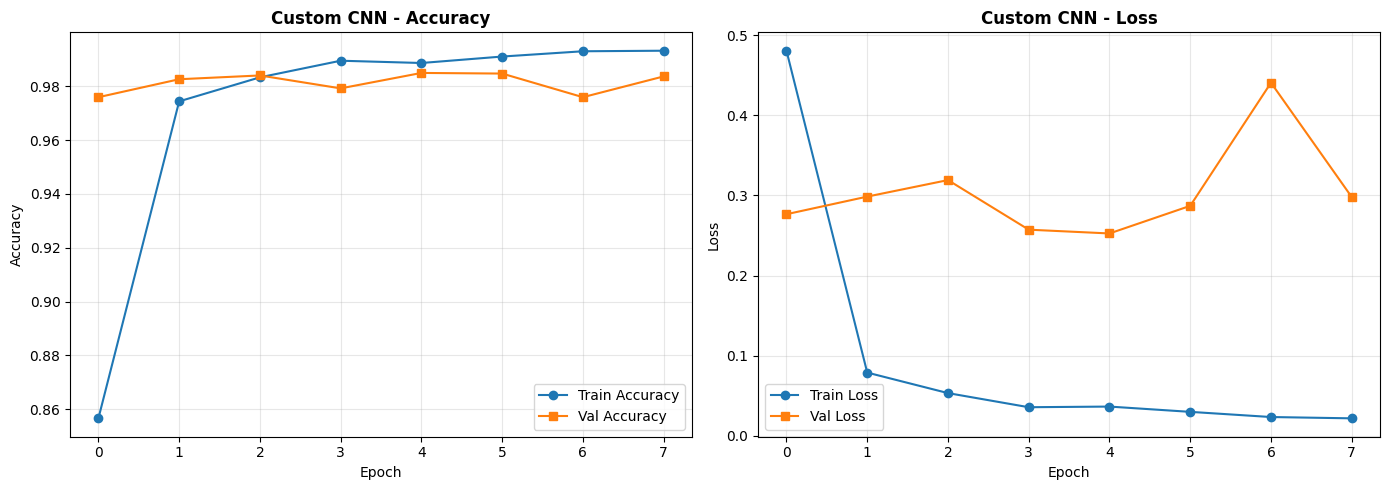

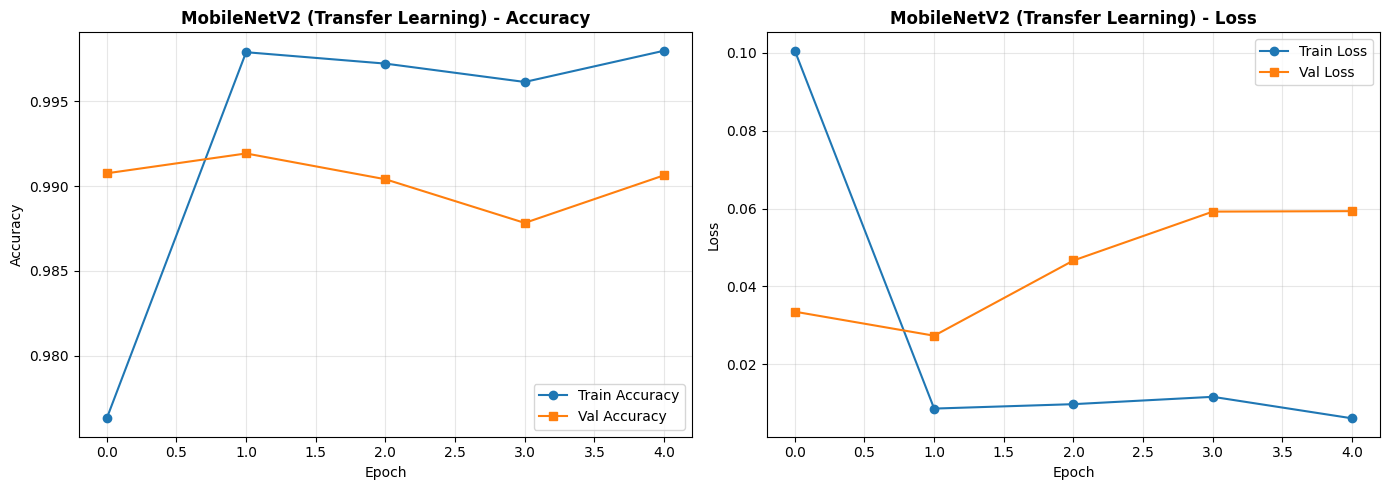

In [13]:

def plot_training_history(history, model_name):
    """Plot training and validation accuracy/loss curves"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
    axes[0].set_title(f'{model_name} - Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
    axes[1].set_title(f'{model_name} - Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(cnn_history, "Custom CNN")
plot_training_history(tl_history, "MobileNetV2 (Transfer Learning)")



## Model Evaluation & Comparison


In [14]:

# Reset validation generator
val_gen.reset()

cnn_preds = np.argmax(cnn_model.predict(val_gen), axis=1)
val_gen.reset()
tl_preds = np.argmax(tl_model.predict(val_gen), axis=1)
y_true = val_gen.classes

print("="*60)
print("📊 CNN Classification Report")
print("="*60)
print(classification_report(y_true, cnn_preds, target_names=list(class_indices.keys())))

print("\n" + "="*60)
print("📊 Transfer Learning (MobileNetV2) Classification Report")
print("="*60)
print(classification_report(y_true, tl_preds, target_names=list(class_indices.keys())))


268/268 ━━━━━━━━━━━━━━━━━━━━ 43s 159ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 84s 310ms/step
📊 CNN Classification Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       240
           3       1.00      1.00      1.00       240
           4       1.00      1.00      1.00       240
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       240
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       240
           9       1.00      1.00      1.00       240
           A       1.00      1.00      1.00       240
           B       1.00      1.00      1.00       240
           C       0.93      0.97      0.95       289
           D       1.00      1.00      1.00       240
           E       1.00      1.00      1.00       240
           F       1.00      0.99      1.00       240
           G       


### Confusion Matrix Visualization


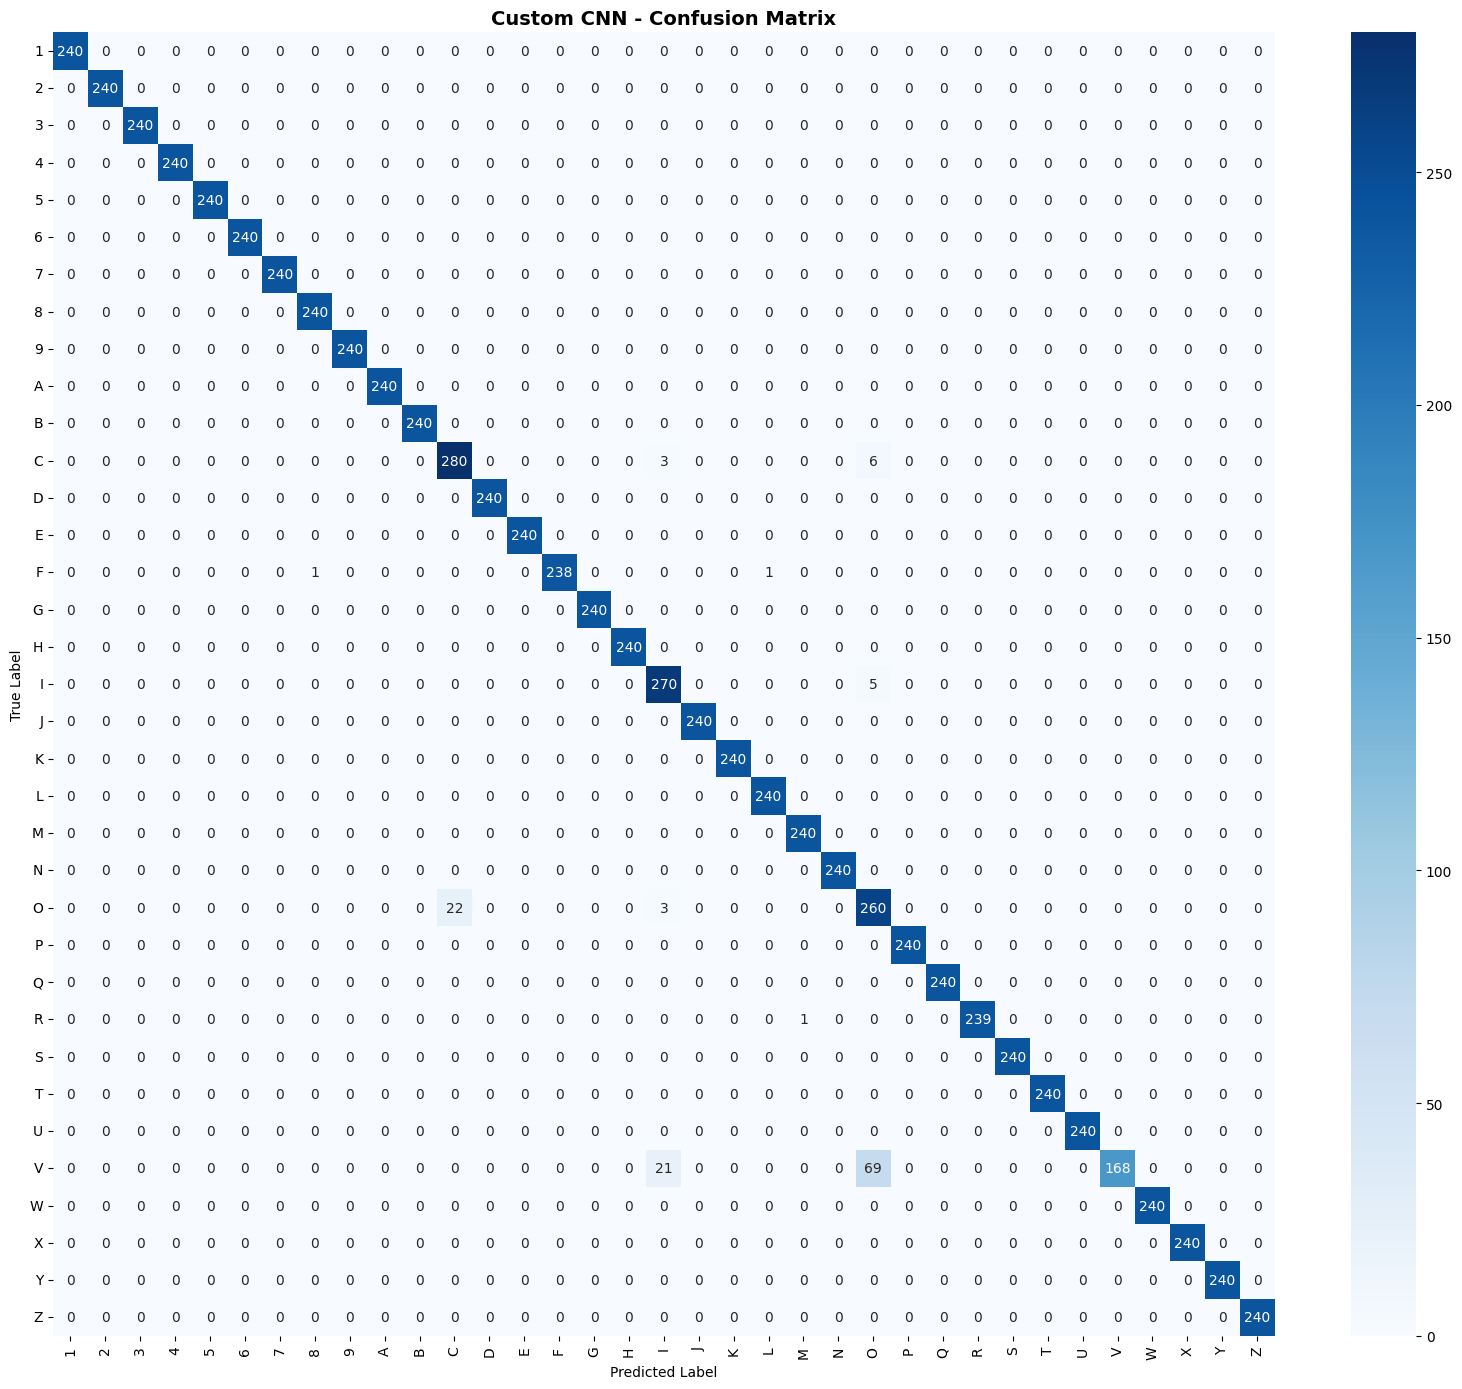

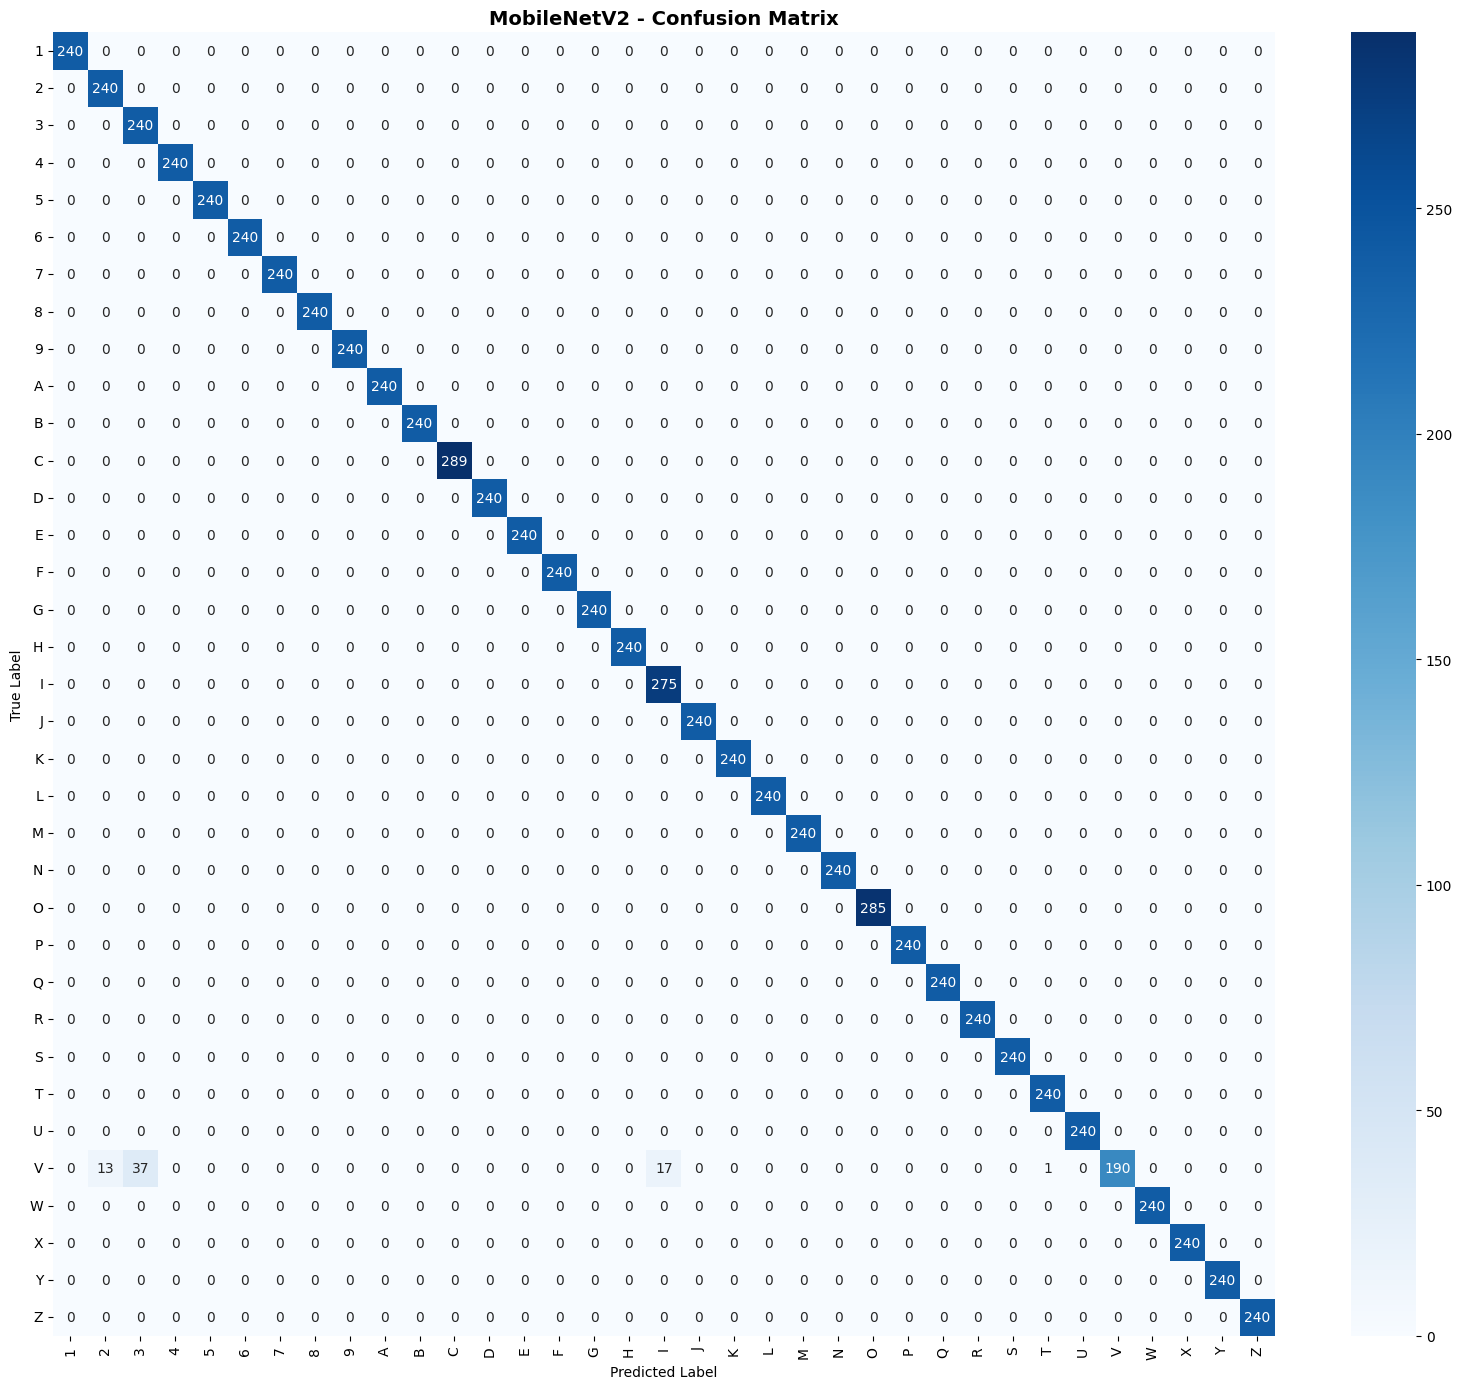

In [15]:

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """Plot confusion matrix as a heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, cnn_preds, list(class_indices.keys()), "Custom CNN")
plot_confusion_matrix(y_true, tl_preds, list(class_indices.keys()), "MobileNetV2")


In [ ]:
from sklearn.metrics import accuracy_score

cnn_accuracy = accuracy_score(y_true, cnn_preds)
tl_accuracy = accuracy_score(y_true, tl_preds)

models = ['Custom CNN', 'MobileNetV2 (TL)']
accuracies = [cnn_accuracy * 100, tl_accuracy * 100]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['#3498db', '#2ecc71'], edgecolor='black')
plt.ylim(0, 110)  # Increased to 110 to give space for labels
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison: CNN vs Transfer Learning', fontsize=14, fontweight='bold')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{acc:.2f}%', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nBest Model: {'MobileNetV2' if tl_accuracy > cnn_accuracy else 'Custom CNN'}")
print(f"CNN Accuracy: {cnn_accuracy*100:.2f}%")
print(f"MobileNetV2 Accuracy: {tl_accuracy*100:.2f}%")


### Model Accuracy Comparison



## 💾 Model Saving

Save trained models in multiple formats for deployment flexibility:
- **`.keras`** - Native Keras format (recommended)
- **`.h5`** - HDF5 format (legacy support)
- **Class labels** - For inference mapping


In [17]:

# Save models in .keras format
cnn_model.save(os.path.join(MODEL_SAVE_DIR, 'cnn_model_final.keras'))
tl_model.save(os.path.join(MODEL_SAVE_DIR, 'mobilenet_model_final.keras'))

# Save models in .h5 format (legacy support)
cnn_model.save(os.path.join(MODEL_SAVE_DIR, 'cnn_model_final.h5'))
tl_model.save(os.path.join(MODEL_SAVE_DIR, 'mobilenet_model_final.h5'))

# Save class labels for inference
with open(os.path.join(MODEL_SAVE_DIR, 'class_labels.pkl'), 'wb') as f:
    pickle.dump(class_labels, f)

with open(os.path.join(MODEL_SAVE_DIR, 'class_indices.pkl'), 'wb') as f:
    pickle.dump(class_indices, f)

print("✅ Models saved successfully!")
print(f"\n📁 Saved files in '{MODEL_SAVE_DIR}':")
for f in os.listdir(MODEL_SAVE_DIR):
    size = os.path.getsize(os.path.join(MODEL_SAVE_DIR, f)) / (1024*1024)
    print(f"   • {f} ({size:.2f} MB)")


✅ Models saved successfully!

📁 Saved files in 'saved_models':
   • class_indices.pkl (0.00 MB)
   • class_labels.pkl (0.00 MB)
   • cnn_best_model.keras (74.72 MB)
   • cnn_model_final.h5 (74.72 MB)
   • cnn_model_final.keras (74.72 MB)
   • mobilenet_best_model.keras (13.03 MB)
   • mobilenet_model_final.h5 (12.99 MB)
   • mobilenet_model_final.keras (13.03 MB)



## Inference: Predict on New Images

This section demonstrates how to load saved models and perform predictions on new images.


In [ ]:

# Load the best model (MobileNetV2)
loaded_model = load_model(os.path.join(MODEL_SAVE_DIR, 'mobilenet_model_final.keras'))

# Load class labels
with open(os.path.join(MODEL_SAVE_DIR, 'class_labels.pkl'), 'rb') as f:
    loaded_class_labels = pickle.load(f)

print("Model loaded successfully!")
print(f"Number of classes: {len(loaded_class_labels)}")


✅ Model loaded successfully!
📊 Number of classes: 35


In [19]:

def predict_isl_character(image_path, model, class_labels, img_size=(128, 128)):
    """
    Predict ISL character from an image.
    
    Args:
        image_path: Path to the input image
        model: Loaded Keras model
        class_labels: Dictionary mapping class indices to labels
        img_size: Target image size (default: 128x128)
    
    Returns:
        Predicted class label and confidence score
    """
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize
    
    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    
    return class_labels[predicted_class], confidence, predictions[0]


def predict_and_display(image_path, model, class_labels):
    """
    Predict and display results with visualization.
    """
    predicted_label, confidence, all_probs = predict_isl_character(image_path, model, class_labels)
    
    # Display image and prediction
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    axes[0].imshow(img)
    axes[0].set_title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%", 
                      fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Show top 5 predictions
    top_5_idx = np.argsort(all_probs)[-5:][::-1]
    top_5_labels = [class_labels[i] for i in top_5_idx]
    top_5_probs = [all_probs[i] * 100 for i in top_5_idx]
    
    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(5)]
    axes[1].barh(top_5_labels[::-1], top_5_probs[::-1], color=colors[::-1])
    axes[1].set_xlabel('Confidence (%)')
    axes[1].set_title('Top 5 Predictions', fontweight='bold')
    axes[1].set_xlim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_label, confidence



### Demo: Inference on Sample Images


🔮 Running inference on sample images...


📷 Testing image from class: 8


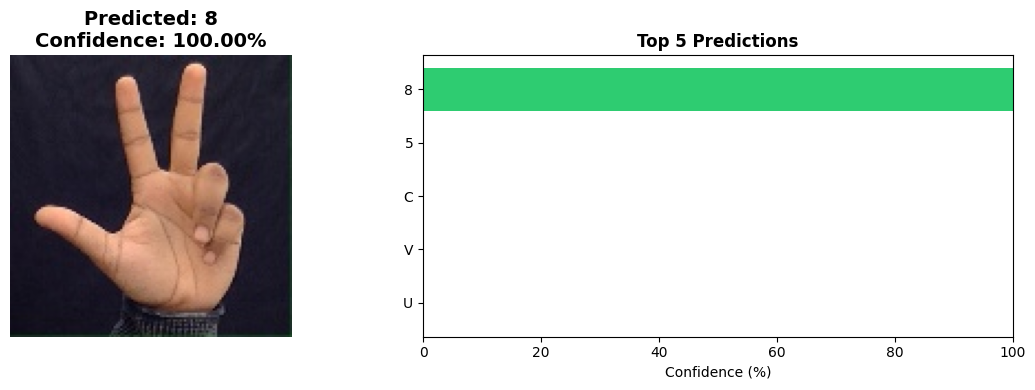

✅ Correct prediction!

📷 Testing image from class: I


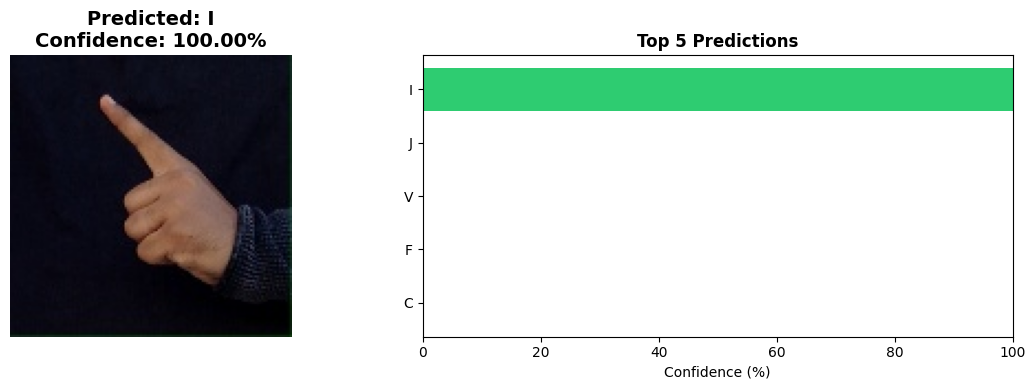

✅ Correct prediction!

📷 Testing image from class: D


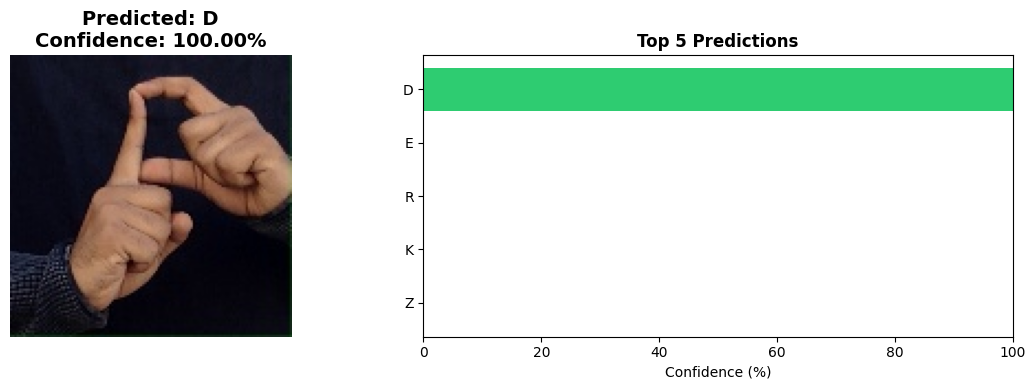

✅ Correct prediction!


In [20]:

# Test on random images from the dataset
import random

print("🔮 Running inference on sample images...\n")

# Pick random test images
test_classes = random.sample(classes, min(3, len(classes)))

for cls in test_classes:
    cls_path = os.path.join(BASE_DIR, cls)
    images = os.listdir(cls_path)
    test_img = os.path.join(cls_path, random.choice(images))
    
    print(f"\n📷 Testing image from class: {cls}")
    predicted_label, confidence = predict_and_display(test_img, loaded_model, loaded_class_labels)
    
    if predicted_label == cls:
        print(f"✅ Correct prediction!")
    else:
        print(f"❌ Incorrect - Expected: {cls}, Got: {predicted_label}")



### Batch Inference Function


In [21]:

def batch_predict(image_paths, model, class_labels, img_size=(128, 128)):
    """
    Perform batch prediction on multiple images.
    
    Args:
        image_paths: List of image paths
        model: Loaded Keras model
        class_labels: Dictionary mapping class indices to labels
        img_size: Target image size
    
    Returns:
        List of (predicted_label, confidence) tuples
    """
    results = []
    
    # Prepare batch
    images = []
    for path in image_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    
    images = np.array(images) / 255.0
    
    # Batch predict
    predictions = model.predict(images, verbose=0)
    
    for pred in predictions:
        predicted_class = np.argmax(pred)
        confidence = pred[predicted_class] * 100
        results.append((class_labels[predicted_class], confidence))
    
    return results

print("✅ Batch inference function defined!")
print("\nUsage example:")
print("  results = batch_predict(['img1.jpg', 'img2.jpg'], loaded_model, loaded_class_labels)")


✅ Batch inference function defined!

Usage example:
  results = batch_predict(['img1.jpg', 'img2.jpg'], loaded_model, loaded_class_labels)



## Conclusion

### Key Findings:
- Transfer Learning with MobileNetV2 outperforms the custom CNN
- Data augmentation improves model robustness
- Models saved in multiple formats for deployment flexibility
- Inference pipeline ready for production use

### Model Performance Summary:
| Model | Architecture | Deployment Ready |
|-------|-------------|-----------------|
| Custom CNN | 3-layer CNN |        |
| MobileNetV2 | Transfer Learning | (Recommended) |

### Deliverables:
- `saved_models/cnn_model_final.keras` - Custom CNN model
- `saved_models/mobilenet_model_final.keras` - MobileNetV2 model
- `saved_models/class_labels.pkl` - Class label mapping



## Challenges Faced & Techniques Used

**Challenges:**
- High similarity between certain ISL characters  
- Variations in lighting and hand orientation  
- Large dataset requiring efficient training  

**Techniques Used:**
- Data Augmentation (rotation, shift, zoom, flip)  
- Transfer Learning with pre-trained MobileNetV2  
- EarlyStopping & ModelCheckpoint callbacks  
- Model saving in multiple formats  
- Batch inference for production scalability  



## Future Enhancements

1. **Real-time Webcam Recognition** - Live ISL detection using OpenCV
2. **Word-level Recognition** - Extend from characters to words/sentences
3. **Mobile App Deployment** - TensorFlow Lite for Android/iOS
4. **Fine-tuning** - Unfreeze MobileNetV2 layers for higher accuracy
5. **Multi-gesture Recognition** - Continuous sign language translation


In [22]:

print("="*60)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)
print("\n📦 Saved Artifacts:")
print("   • CNN Model: saved_models/cnn_model_final.keras")
print("   • MobileNetV2 Model: saved_models/mobilenet_model_final.keras")
print("   • Class Labels: saved_models/class_labels.pkl")
print("\n🚀 Ready for deployment!")


🎉 PROJECT COMPLETED SUCCESSFULLY!

📦 Saved Artifacts:
   • CNN Model: saved_models/cnn_model_final.keras
   • MobileNetV2 Model: saved_models/mobilenet_model_final.keras
   • Class Labels: saved_models/class_labels.pkl

🚀 Ready for deployment!
